In [2]:
import requests
import pandas as pd
import io
import numpy as np

# Define the SPARQL endpoint
endpoint = "https://www.govdata.de/sparql"

# Get the proxy URL
proxy_url = requests.utils.getproxies().get('http')

# Set the proxy configuration
proxies = {'http': proxy_url}



query = """
PREFIX foaf: <http://xmlns.com/foaf/0.1/>
PREFIX dcat: <http://www.w3.org/ns/dcat#>
PREFIX dct: <http://purl.org/dc/terms/>
PREFIX dcatde: <http://dcat-ap.de/def/dcatde/>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>

SELECT ?dataset ?title ?publisher_name ?distribution_link ?publication_year
WHERE {
  ?dataset a dcat:Dataset ;
            dct:title ?title ;
            dcat:distribution ?distribution ;
            dct:publisher ?publisher .
  OPTIONAL {?publisher foaf:name ?publisher_name} .
  FILTER(REGEX(lcase(?publisher_name),'^bm.*|bundesminist.*|^ausw.*|^aa$')) .
  OPTIONAL { ?distribution dcat:accessURL ?distribution_link } .
  OPTIONAL { ?dataset dct:issued ?publication_date } .
  BIND (year(?publication_date) as ?publication_year)
}
"""

# Send the SPARQL query and get the response in CSV format
url = endpoint + '?query=' + requests.utils.quote(query, safe='')
headers = {'Accept': 'text/csv'}
response = requests.get(url, headers=headers, proxies=proxies, timeout=60)

# Convert the CSV response to a Pandas DataFrame
df = pd.read_csv(io.StringIO(response.content.decode('utf-8')))

# Delete unnecessary variables
del endpoint, proxy_url, proxies, query, url, headers, response


In [3]:
# Use np.select to create a new column publisher_short with the short publisher name
conditions = [
    df['publisher_name'].str.contains('Wirtschaft und|BMWK|BMWI', case=False),
    df['publisher_name'].str.contains('Finanzen|^BMF', case=False),
    df['publisher_name'].str.contains('Innern|^BMI', case=False),
    df['publisher_name'].str.contains('^Ausw|^AA', case=False),
    df['publisher_name'].str.contains('Justitz|BMJ', case=False),
    df['publisher_name'].str.contains('Arbeit|BMAS', case=False),
    df['publisher_name'].str.contains('Verteidigung|BMVg', case=False),
    df['publisher_name'].str.contains('Landwirtschaft|BMEL', case=False),
    df['publisher_name'].str.contains('Familie|BMFSFJ', case=False),
    df['publisher_name'].str.contains('Gesundheit|BMG', case=False),
    df['publisher_name'].str.contains('Verkehr|BMDV', case=False),
    df['publisher_name'].str.contains('Umwelt|BMUV', case=False),
    df['publisher_name'].str.contains('Bildung|BMBF', case=False),
    df['publisher_name'].str.contains('Entwicklung|BMZ', case=False),
    df['publisher_name'].str.contains('Wohnen|BMWSB', case=False),
    df['publisher_name'].str.contains('Bundeskanzleramt|BKAmt', case=False)
]

choices = ['BMWK', 'BMF', 'BMI', 'AA', 'BMJ', 'BMAS', 'BMVg', 'BMEL', 'BMFSFJ', 'BMG', 'BMDV', 'BMUV', 'BMBF', 'BMZ', 'BMWSB', 'BKAmt']
df['publisher_short'] = np.select(conditions, choices, default='other')

# Create factor column for the publisher_short column
df['publisher_short'] = pd.Categorical(df['publisher_short'], categories=choices, ordered=True)

# Delete variables that are not needed anymore
del choices, conditions

In [14]:
# Subset the file format from the distribution_link column
df['file_format'] = df['distribution_link'].str.split('.').str[-1]

# Change all values in file_column to 'csv' that contain '.csv' and all to 'json' that contain '.json'
df.loc[df['distribution_link'].str.contains('csv', case=False), 'file_format'] = 'csv'
df.loc[df['distribution_link'].str.contains('json', case=False), 'file_format'] = 'json'
df.loc[df['distribution_link'].str.contains('pdf', case=False), 'file_format'] = 'pdf'
df.loc[df['distribution_link'].str.contains('xlsx', case=False), 'file_format'] = 'xlsx'
df.loc[df['distribution_link'].str.contains('xls[^x]', case=False), 'file_format'] = 'xls'
df.loc[df['distribution_link'].str.contains('xlm', case=False), 'file_format'] = 'xlm'

# Change all values in file_column to 'other' that are longer than 4 characters
df.loc[df['file_format'].str.len() > 5, 'file_format'] = 'other link'

# Count number of occurences and change all to 'other' that occur fewer than 5 times
df['file_format'] = df['file_format'].where(df['file_format'].map(df['file_format'].value_counts()) > 5, 'other link')


# Export df to CSV
#df.to_csv('output/govdata.csv', index=False)

In [7]:
# Count number of occurences in file_format 
df_file_format = df['file_format'].value_counts()
print(df_file_format)



other link    692
csv           515
pdf           405
html          381
xls           347
xml           168
xlsx           73
zip            12
txt             7
json            6
Name: file_format, dtype: int64


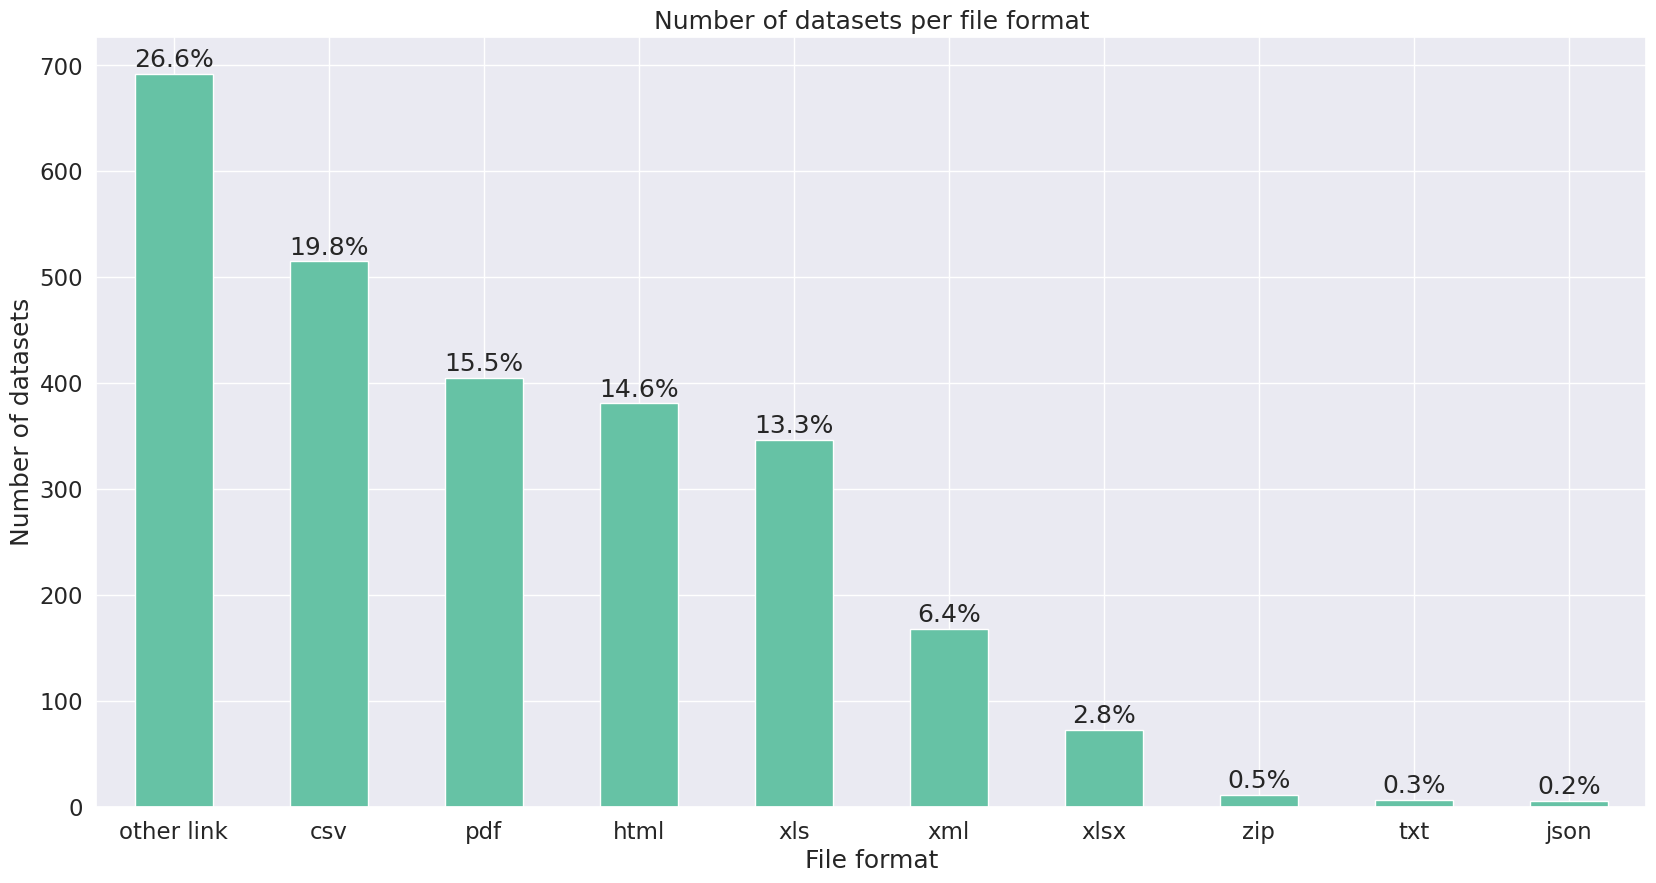

In [15]:
# Plot df_file_format
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style
sns.set_style("whitegrid")

# Set the font scale
sns.set(font_scale=1.5)

# Set the color palette
sns.set_palette("Set2")

# Create the plot
ax = df_file_format.plot(kind='bar', figsize=(20,10), title='Number of datasets per file format')

# Set the labels
ax.set_xlabel('File format')
ax.set_ylabel('Number of datasets')

# Set the x-axis labels to horizontal
ax.tick_params(axis='x', labelrotation=0)

# Add the percentages
for p in ax.patches:
    ax.annotate('{:.1f}%'.format(100 * p.get_height() / df_file_format.sum()), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# Show the plot
plt.show()


In [18]:
# Get only distinct datasets
df_distinct = df.drop_duplicates(subset=['dataset'])

In [38]:
# Count the number of datasets per publisher
df_distinct_publ = df_distinct['publisher_short'].value_counts()


# Add the percentages
#df_distinct_publ = df_distinct_publ.to_frame()
#df_distinct_publ['percentage'] = df_distinct_publ['publisher_short'] / df_distinct_publ['publisher_short'].sum()
#df_distinct_publ = df_distinct_publ.round(3)

print(df_distinct_publ)

BMBF      387
BMDV      278
BMAS       63
BMFSFJ     60
BMF        54
BMI        25
BMWK       20
BMZ        11
AA          8
BMEL        6
BMVg        4
BMG         3
BMJ         0
BMUV        0
BMWSB       0
BKAmt       0
Name: publisher_short, dtype: int64


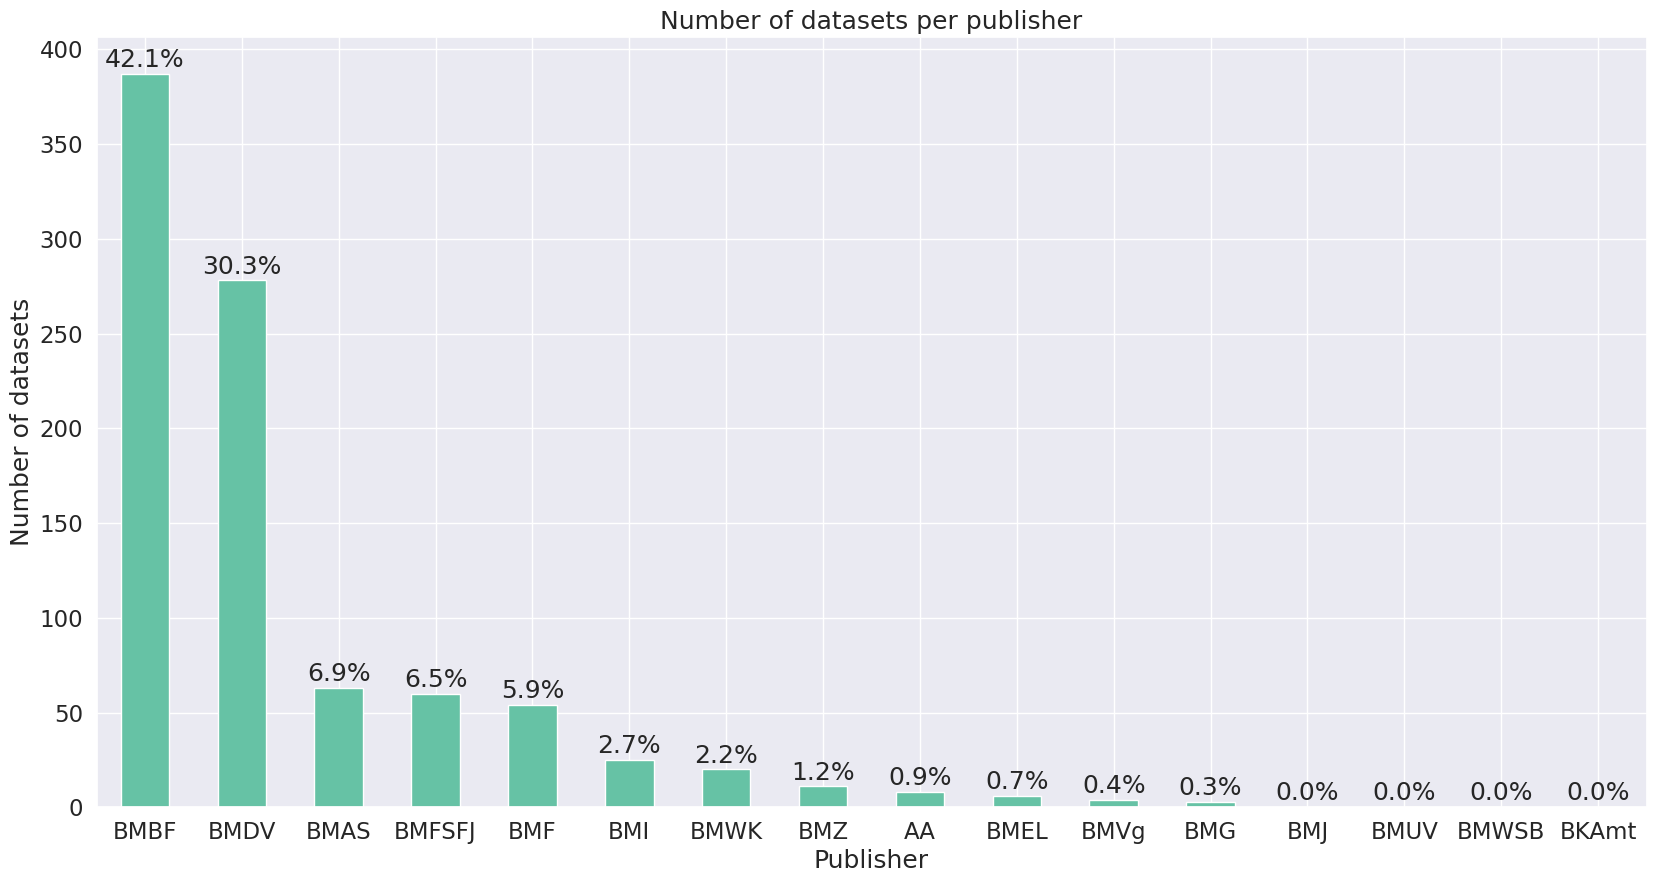

In [39]:
# Plot df_distinct_publ with Seaborn
ax = df_distinct_publ.plot(kind='bar', figsize=(20,10), title='Number of datasets per publisher')

# Set the labels
ax.set_xlabel('Publisher')
ax.set_ylabel('Number of datasets')

# Set the x-axis labels to horizontal
ax.tick_params(axis='x', labelrotation=0)

# Add the percentages
for p in ax.patches:
    ax.annotate('{:.1f}%'.format(100 * p.get_height() / df_distinct_publ.sum()), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# Show the plot
plt.show()





In [44]:
random_rows = df.sample(n=30)

In [48]:
import requests

# List of URLs to check
# urls = random_rows.distribution_link
urls = df.distribution_link
# Create a list of dictionaries to store the results
results = []

# Check the status of each URL and store the result in the list of dictionaries
for url in urls:
    try:
        response = requests.get(url)
        if response.status_code == 200:
            status = "OK"
        else:
            status = f"Error {response.status_code}"
    except requests.exceptions.RequestException as e:
        status = f"Error {e}"
    results.append({"url": url, "status": status})

# Create a DataFrame from the list of dictionaries
results_url_status = pd.DataFrame(results)

# Save the DataFrame to a CSV file
results_url_status.to_csv("output/results_url_status.csv", index=False)

# Print the DataFrame
print(results_url_status)

# Delete variables that are not needed anymore
del results, response, url, urls

                                                    url status
0     https://www.datenportal.bmbf.de/portal/de/bild...     OK
1     https://www.datenportal.bmbf.de/portal/Tabelle...     OK
2     https://www.datenportal.bmbf.de/portal/Tabelle...     OK
3     https://www.datenportal.bmbf.de/portal/Tabelle...     OK
4     https://www.datenportal.bmbf.de/portal/Tabelle...     OK
...                                                 ...    ...
2601  https://www.bmas.de/SharedDocs/Downloads/DE/Re...     OK
2602  https://www.bmas.de/SharedDocs/Downloads/DE/Re...     OK
2603  https://www.bmas.de/SharedDocs/Downloads/DE/Re...     OK
2604  https://www.bmas.de/SharedDocs/Downloads/DE/Re...     OK
2605  https://www.bmas.de/SharedDocs/Downloads/DE/Re...     OK

[2606 rows x 2 columns]


NameError: name 'random_rows' is not defined

In [54]:
# Save the df results_url_status to a CSV file with actual date in the filename

from datetime import datetime
results_url_status.to_csv(f"output/results_url_status_{datetime.now().strftime('%Y%m%d')}.csv", index=False)

In [49]:
# Save the results_url_status to a CSV file
results_url_status.to_csv("output/results_url_status.csv", index=False)

In [50]:
(results_url_status["status"] == "OK").sum()

2474

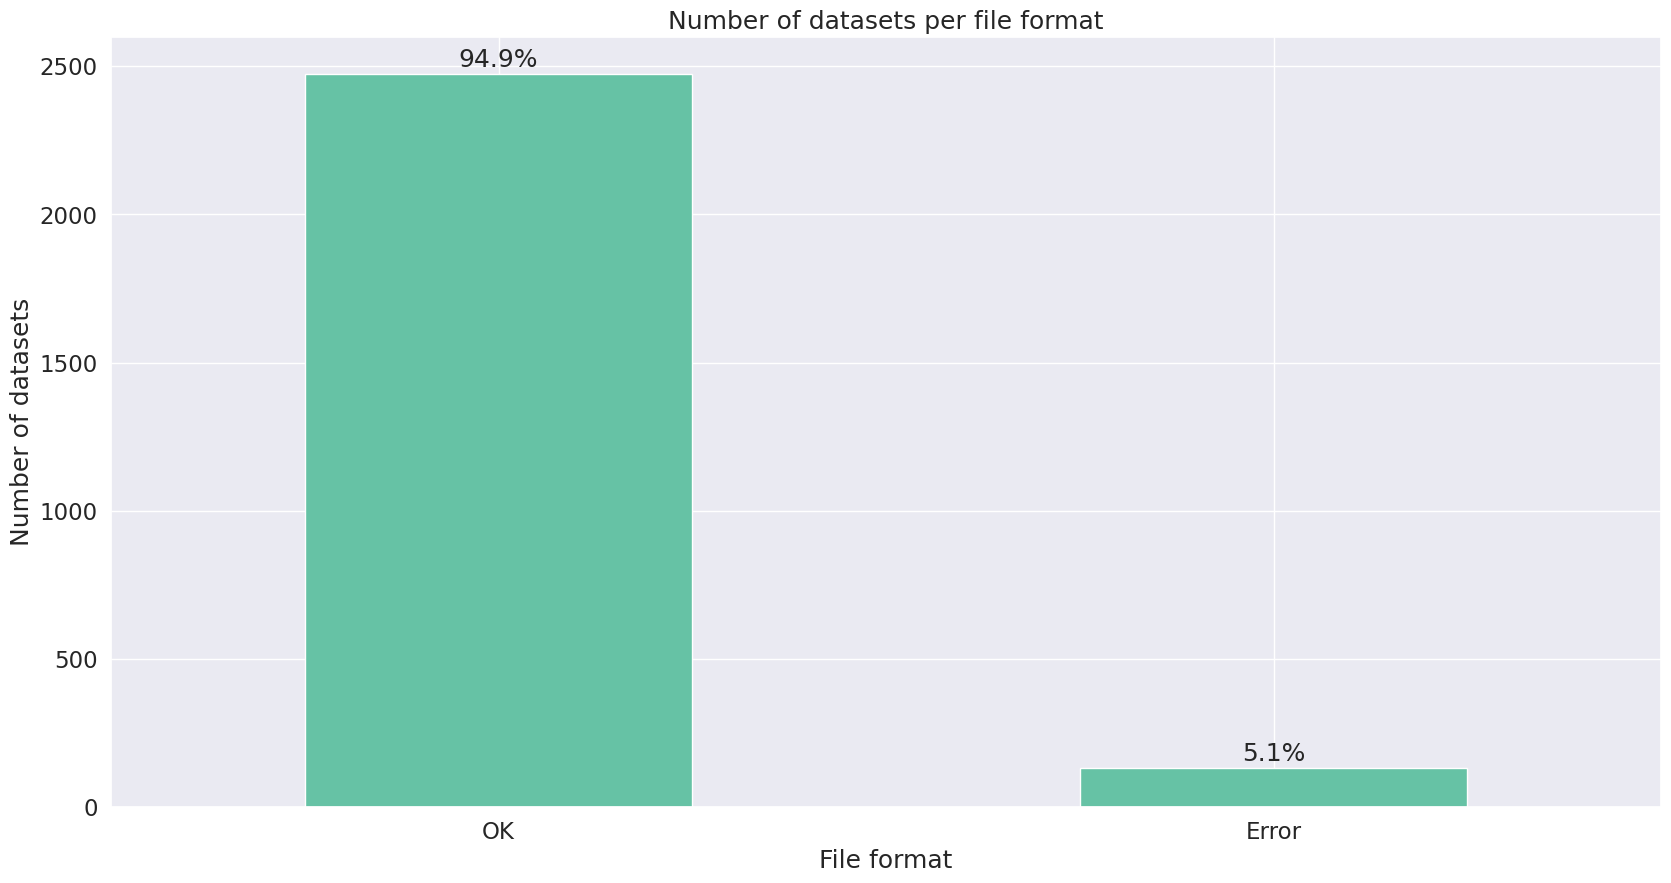

In [52]:
# Plot results_url_status with Seaborn

# Set the style
sns.set_style("whitegrid")

# Set the font scale
sns.set(font_scale=1.5)

# Set the color palette
sns.set_palette("Set2")

# Create the plot
ax = results_url_status['status'].value_counts().plot(kind='bar', figsize=(20,10), title='Number of datasets per file format')

# Set the labels
ax.set_xlabel('File format')
ax.set_ylabel('Number of datasets')

# Set the x-axis labels to horizontal
ax.tick_params(axis='x', labelrotation=0)

# Add the percentages
for p in ax.patches:
    ax.annotate('{:.1f}%'.format(100 * p.get_height() / results_url_status['status'].value_counts().sum()), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# Show the plot
plt.show()


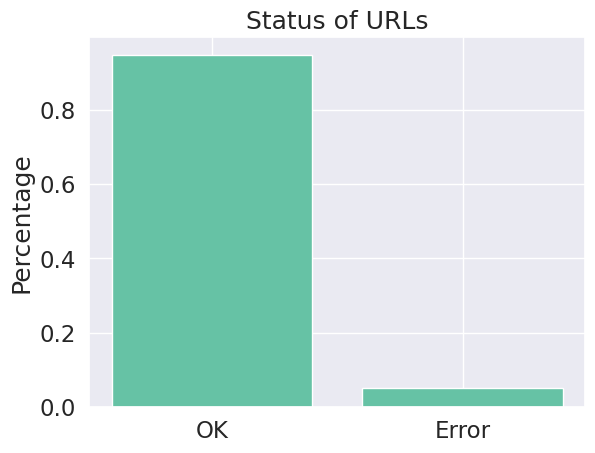

In [51]:
import matplotlib.pyplot as plt

# Replace all non-"OK" cells in the "status" column with "Error"
results_url_status.loc[results_url_status["status"] != "OK", "status"] = "Error"

# Group the DataFrame by status and count the number of URLs with each status
grouped = results_url_status.groupby("status").size()

# Calculate the percentage of "OK" and "Error" values
ok_percent = (results_url_status["status"] == "OK").sum() / len(results_url_status)
error_percent = (results_url_status["status"] == "Error").sum() / len(results_url_status)

# Plot the percentages as a bar chart
plt.bar(["OK", "Error"], [ok_percent, error_percent])
plt.ylabel("Percentage")
plt.title("Status of URLs")
plt.show()